In [ ]:
import os
import numpy as np 
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from tqdm import tqdm
from shapely.geometry import Point,Polygon
import seaborn as sns
%matplotlib inline


sh_od = pd.read_csv('./data-sample/sh_od.csv')
print (sh_od.head())
sh_od = sh_od[['vehicle_num','date','longitude','latitude','status']]
sh_od.info()

### 初步的数据理解
经过如上的简单分析，可以得到几个如下结论
1. 处理过后的数据是2822辆出租车，在上海的于2007年2月20日的行驶数据
2. 有些出租车行驶范围超出了上海的行政范围
3. 每到3-5分钟获取一次状态

### 任务
1. 将时间分为24段，分析每一时间段，出租车的位置分布，图表表示。以此判断上海的交通情况
2. 将1）生成的分布图做成视频，平均一分钟一帧。大概60*24=1440帧
3. 从出发点与到达点分析，判断哪些地方比较热门
4. 按照行政区划，构建不同地区的交通情况图

### 计划


每个时间段出租车的分布图。考虑到时间选取是区间，故取在这段时间内出租车位置的经纬度的均值

In [ ]:
# print (sh_od.info())
print (sh_od.head())
sh_od['hour'] = sh_od['date'].apply(lambda x: x[11:13])
pos_longitude_mean = lambda x: np.mean(x['longitude'])
pos_latitude_mean = lambda x: np.mean(x['latitude'])

pos_per_hour_list = []
for hour in range(24):
    if hour>=0 and hour<=9:
        hour = f'0{hour}'
    else:
        hour = str(hour)
    pos_per_hour = gpd.GeoDataFrame()
    pos_per_hour['longitude'] = sh_od[sh_od['hour']==hour].groupby('vehicle_num').apply(pos_longitude_mean)
    pos_per_hour['latitude'] = sh_od[sh_od['hour']==hour].groupby('vehicle_num').apply(pos_latitude_mean)
    pos_per_hour['geometry'] = pos_per_hour.apply(lambda x: Point(x.iloc[0],x.iloc[1]),axis=1)
    pos_per_hour_list.append(pos_per_hour)

pos_per_hour.info()
# sh_od[sh_od['hour']=='08'].shape

   vehicle_num                 date   longitude  latitude  status
0        10004  2007-02-20 00:08:45  121.414583     31.16       1
1        10004  2007-02-20 00:11:55  121.414583     31.16       1
2        10004  2007-02-20 00:18:13  121.414583     31.16       1
3        10004  2007-02-20 00:24:31  121.414583     31.16       1
4        10004  2007-02-20 00:27:40  121.414583     31.16       1
<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 2739 entries, 105 to 99780
Data columns (total 3 columns):
longitude    2739 non-null float64
latitude     2739 non-null float64
geometry     2739 non-null geometry
dtypes: float64(2), geometry(1)
memory usage: 85.6 KB


画图-出租车司机空间分布图

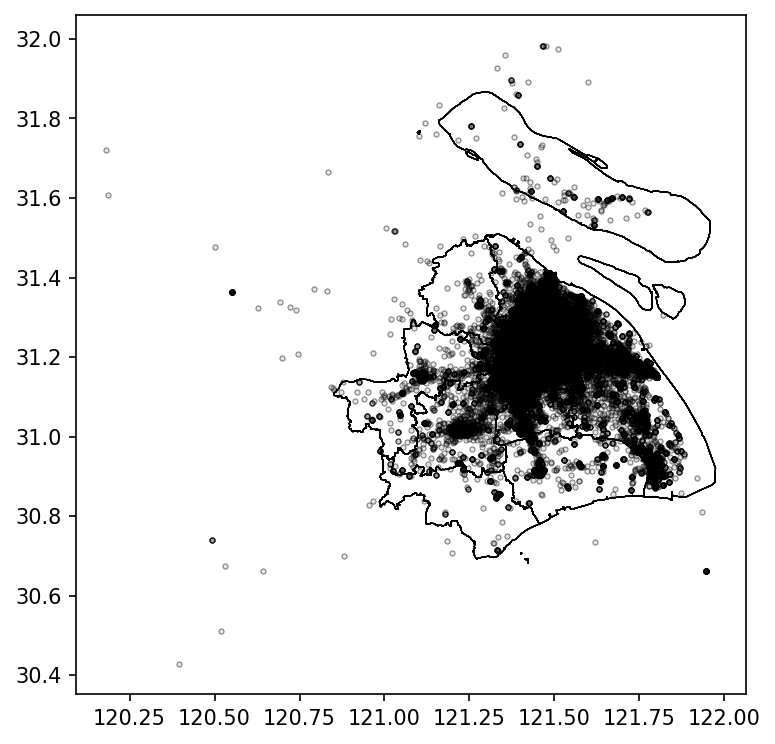

In [ ]:
import warnings
warnings.filterwarnings('ignore')

sh_xzgh = gpd.GeoDataFrame.from_file('./shapefile/shanghai_shp/区县界_area.shp')

for i,pos_per_hour in enumerate(pos_per_hour_list):
    #generate figure
    fig     = plt.figure(1,(6,6),dpi = 150)    
    #add a subplot
    ax      = plt.subplot(111)
    #tell python we are going to plot in this subplot
    plt.sca(ax)

    #plot the grids on the ax
    pos_per_hour.plot(ax =ax,edgecolor = (0,0,0,0.5),facecolor = (0,0,0,0.1),linewidths=0.5,markersize=6)

    #Transform the merged administrative division into a geodataframe, and draw it on ax
    sh_all = gpd.GeoDataFrame()
    # sh_all['geometry'] = [sh_xzgh.unary_union]
    sh_xzgh.plot(ax = ax,edgecolor = (0,0,0,1),facecolor = (0,0,0,0),linewidths=0.5)
    plt.savefig(f'./images/hour{i}_distribution.png')


制作视频

In [ ]:
import cv2
import os

image_folder = 'images'
video_name = './images/video.gif'

images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
frame = cv2.imread(os.path.join(image_folder, images[0]))
height, width, layers = frame.shape

video = cv2.VideoWriter(video_name, 0, 1, (width,height))

for image in images:
    file = cv2.imread(os.path.join(image_folder, image))
    video.write(file)

cv2.destroyAllWindows()
video.release()

# cv2.destroyAllWindows()